In [ ]:
import cv2
import matplotlib.pyplot as plt

In [18]:
import pandas as pd

DATA_DIR = "./hw3_dataset"
train_df = pd.read_csv(f"{DATA_DIR}/train.csv")

In [19]:
train_df

,case,day,slice,class,segmentation
0,46,20.0,1.0,large_bowel,NaN
1,46,20.0,1.0,small_bowel,NaN
2,46,20.0,1.0,stomach,NaN
3,46,20.0,2.0,large_bowel,NaN
4,46,20.0,2.0,small_bowel,NaN
...,...,...,...,...,...
17707,0,4.0,143.0,small_bowel,NaN
17708,0,4.0,143.0,stomach,NaN
17709,0,4.0,144.0,large_bowel,NaN
17710,0,4.0,144.0,small_bowel,NaN


In [31]:
# case	day	slice	class	segmentation
# 0	46	20.0	1.0	large_bowel	NaN
# 1	46	20.0	1.0	small_bowel	NaN

# -> DATA_DIR/train/case60/day0/slice_1.png

train_df['image_path'] = f'{DATA_DIR}/train/' + 'case' + train_df['case'].astype(str) + '/day' + train_df['day'].astype(int).astype(str) + \
    '/slice_' + train_df['slice'].astype(int).astype(str) + '.png'
train_df.head()

,case,day,slice,class,segmentation,image_path
0,46,20.0,1.0,large_bowel,NaN,./hw3_dataset/train/case46/day20/slice_1.png
1,46,20.0,1.0,small_bowel,NaN,./hw3_dataset/train/case46/day20/slice_1.png
2,46,20.0,1.0,stomach,NaN,./hw3_dataset/train/case46/day20/slice_1.png
3,46,20.0,2.0,large_bowel,NaN,./hw3_dataset/train/case46/day20/slice_2.png
4,46,20.0,2.0,small_bowel,NaN,./hw3_dataset/train/case46/day20/slice_2.png


### **Load Image**

In [316]:
case = '0'
day = '1'
slice_id = '85'

row = train_df[((train_df['case']) == int(case)) &
               ((train_df['day']) == int(day)) &
               ((train_df['slice']) == int(slice_id))]

In [317]:
row

,case,day,slice,class,segmentation,image_path,fold
15804,0,1.0,85.0,large_bowel,19329 5 19593 9 19859 11 20124 14 20390 15 206...,./hw3_dataset/train/case0/day1/slice_85.png,0
15805,0,1.0,85.0,small_bowel,22008 4 22272 8 22537 9 22802 11 23045 8 23068...,./hw3_dataset/train/case0/day1/slice_85.png,0
15806,0,1.0,85.0,stomach,19016 5 19279 9 19542 13 19807 14 20072 15 203...,./hw3_dataset/train/case0/day1/slice_85.png,0


In [319]:
row['image_path']

15804    ./hw3_dataset/train/case0/day1/slice_85.png
15805    ./hw3_dataset/train/case0/day1/slice_85.png
15806    ./hw3_dataset/train/case0/day1/slice_85.png
Name: image_path, dtype: object

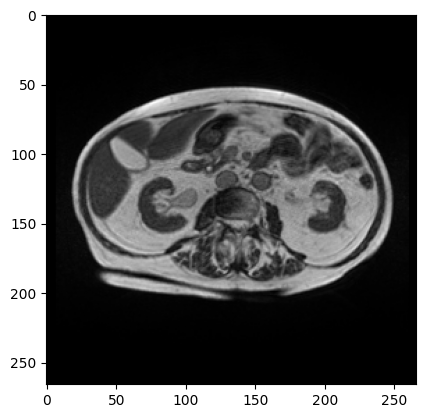

In [320]:
img = cv2.imread(row['image_path'].iloc[0], -1)
plt.imshow(img, cmap='gray')

### **Decode Mask**

In [321]:
import numpy as np

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [322]:
classes = ['stomach', 'small_bowel', 'large_bowel']

def get_mask(case, day, slice_id):
    h, w = 266, 266 # keep this fixed!!!
    sub_df = train_df[((train_df['case']) == int(case)) &
                      ((train_df['day']) == int(day)) &
                      ((train_df['slice']) == int(slice_id))]
    mask = np.zeros((h, w, len(classes)), dtype=np.uint8)
    for i, cls in enumerate(classes):
        rle = sub_df.loc[sub_df['class'] == cls, 'segmentation'].values
        if len(rle) and not pd.isna(rle[0]):
            mask[..., i] = rle_decode(rle[0], shape=(h, w))
    return mask

In [323]:
mask = get_mask(case, day, slice_id)
mask.shape

(266, 266, 3)

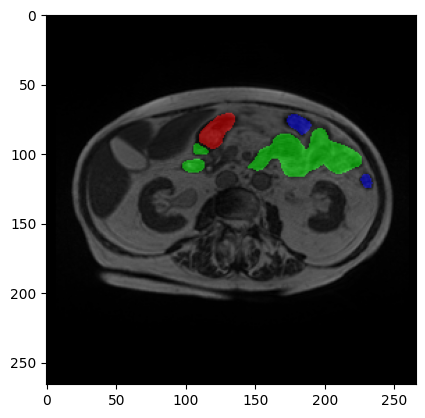

In [324]:
plt.imshow(img, cmap='gray')
plt.imshow(mask * 255, alpha=0.5)